# Ferret data
First, we load the imaging data used in Macke et al. (2011). Its size is (npixels_x, npixels_y, conditions, trials).

In [2]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and take a 40x40 pixel patch.

In [3]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))
print(R.shape)

# take only a small part of the image (for performance reasons)
R = R[:,:,38:58,106:136]

# downsample image
#R = R[:,:,::3,::3]

size = R.shape[2:]
n = size[0] * size[1]
R.shape

(8, 100, 100, 200)


(8, 100, 20, 30)

## Plot responses
Visualize the responses for the small patch

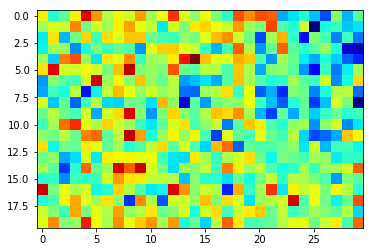

In [4]:
plt.imshow(R[0,np.random.randint(100),:,:], cmap='jet')
plt.show()

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [5]:
from opm import calculate_map, plot_opm, plot_amplitude_map
from opm.response import create_stimuli

In [6]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 100)
V.shape

(8, 100, 3)

In [7]:
m = calculate_map(R, V)
m_hat = m[0] + 1j * m[1]

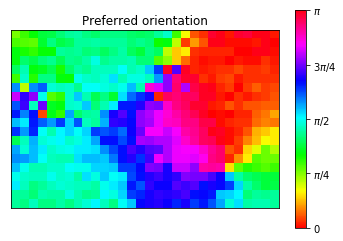

In [8]:
plot_opm(m_hat, pinwheels=False, shade=False, rmax=80)
plt.show()

## Gaussian Process method
Compute a smooth OPM using the GP method (see BayesianOPM.ipynb)

In [9]:
from opm.gp import GaussianProcessOPM

In [10]:
gp = GaussianProcessOPM(size=R.shape[2:], prior_method='icd', prior_rank=500)

In [11]:
mu_post = gp.fit(stimuli=V, responses=R, noise='factoran', verbose=True, noise_kwargs={'iterations':3, 'q':2})

*** Estimating prior hyperparameters ***
{'sigma': 4.441399047063159, 'alpha': 2.8433287234972293}
*** Fitting prior ***
*** Fitting posterior ***
Fitting noise model: iteration 1
Fitting noise model: iteration 2
Fitting noise model: iteration 3


In [14]:
d = 3
N = 800
mhat = calculate_map(R, V).reshape((d,n))

G = gp.prior.G
K = G @ G.T + gp.prior.D
beta = 2 / N

noise_cov = gp.noise.D + gp.noise.G @ gp.noise.G.T
S = np.linalg.inv(self.noise.covariance)

K_post_c = K - 1 / beta * K @ (S - S @ G @ np.linalg.inv(beta * np.eye(gp.rank) + G.T @ S @ G) @ G.T @ S) @ K

mu_post = np.kron(np.eye(d), K_post_c @ S) @ mhat.reshape((d*n, 1))

In [17]:
mu_post = mu_post.reshape((d,*size))

In [20]:
test1 = (K_post_c @ S)

In [25]:
test1.shape

(600, 600)

In [24]:
from opm.gp.lowrank import premult_by_postcov
test2 = premult_by_postcov(np.eye(n), N, gp.prior, gp.noise)
test2.shape

(600, 600)

In [194]:
mu_post2

array([[[-6.98662623e-04, -2.05447973e-04,  3.36304005e-04, ...,
         -8.36543066e-03, -5.94634630e-03, -3.77913662e-03],
        [-2.05725125e-04, -1.65655698e-04,  9.53183515e-05, ...,
         -7.73582219e-03, -5.75113244e-03, -3.22275547e-03],
        [ 3.49589603e-04,  1.47568539e-04,  2.41912733e-04, ...,
         -7.16312371e-03, -5.11339028e-03, -2.66459550e-03],
        ...,
        [ 4.75533739e-04, -5.03073931e-04, -1.31625721e-03, ...,
         -1.06889785e-02, -1.15476899e-02, -1.18843772e-02],
        [ 1.44029315e-03,  4.76981751e-04, -1.44827452e-04, ...,
         -1.05953239e-02, -1.09452550e-02, -1.13257039e-02],
        [ 2.41712299e-03,  1.74799185e-03,  9.41404941e-04, ...,
         -9.42306669e-03, -1.00438328e-02, -1.02928183e-02]],

       [[ 7.94328293e-04,  8.40352833e-04,  8.38685328e-04, ...,
          1.22604827e-03,  1.07952617e-03,  9.10174891e-04],
        [ 8.23599348e-04,  8.50466902e-04,  8.74333746e-04, ...,
          1.22240465e-03,  1.12267984e

In [18]:
#mu = m.reshape(3, size)
result = mu_post[0] + 1j * mu_post[1]

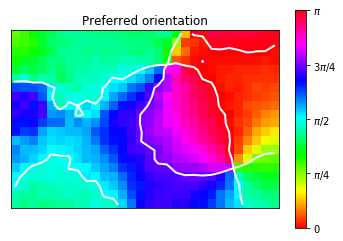

In [19]:
f, ax = plot_opm(result)

### Noise covariance
We examine the noise variances (i.e. the diagonal of the noise covariance matrix).

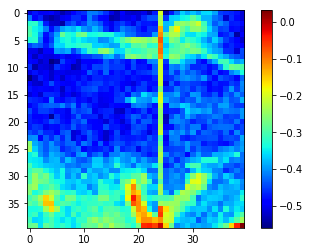

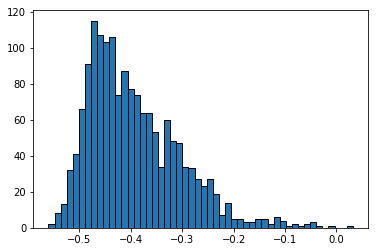

In [53]:
noise_cov = gp.noise.D + gp.noise.G @ gp.noise.G.T
noise_var = np.diag(noise_cov)

plt.imshow(np.log10(noise_var).reshape(*R.shape[2:]), cmap='jet')
plt.colorbar()
plt.show()

plt.hist(np.log10(noise_var), bins=50, edgecolor='black')
plt.show()

In [14]:
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    std_mat = np.tile(std, (cov.shape[0],1))
    return cov / std_mat / std_mat.T

cov2corr(gp.noise_cov)

array([[ 1.        ,  0.11620494, -0.04739863, ...,  0.08275058,
         0.06044977,  0.07859663],
       [ 0.11620494,  1.        , -0.03689163, ...,  0.08178572,
         0.06209477,  0.07884165],
       [-0.04739863, -0.03689163,  1.        , ...,  0.00133604,
         0.01161343,  0.00652673],
       ...,
       [ 0.08275058,  0.08178572,  0.00133604, ...,  1.        ,
         0.07908519,  0.09265703],
       [ 0.06044977,  0.06209477,  0.01161343, ...,  0.07908519,
         1.        ,  0.08175567],
       [ 0.07859663,  0.07884165,  0.00652673, ...,  0.09265703,
         0.08175567,  1.        ]])

In [15]:
def avg_neighbor_corr(gp, radius=2):
    
    # size of the map (x, y)
    size = gp.size
    
    # convert noise covariance to correlation matrix
    noise_corr = cov2corr(gp.noise_cov)
    
    # initialize empty image
    neighbor_corr = np.zeros(size)
    
    # for each index
    # i is the 1d index
    # ix is the 2d (x, y) index
    for i, ix in enumerate(gp.idx):
        # compute euclidean distance from this index to all others
        dist = np.sqrt(np.sum(np.square(ix - gp.idx), axis=1))
        
        # keep all indices smaller than some distance
        neighbors = np.where(dist <= radius)[0]
        # remove the index itself
        neighbors = neighbors[neighbors != i]
    
        # compute average correlation between i and the neighbors
        neighbor_corr[ix[0], ix[1]] = np.mean(noise_corr[i, neighbors])
            
    return neighbor_corr

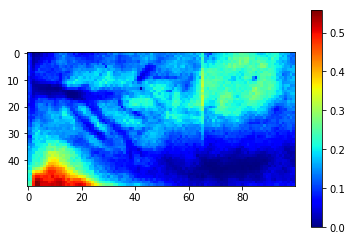

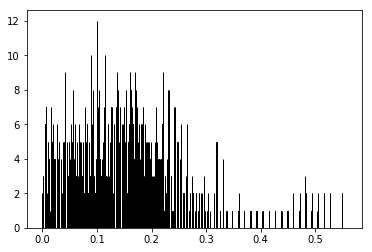

In [16]:
nbcorr = avg_neighbor_corr(gp, radius=2)

plt.imshow(nbcorr, cmap='jet')
plt.colorbar()
plt.show()

plt.hist(nbcorr, bins=50, edgecolor='black')
plt.show()